In [51]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from test_model import test_model
from train_model import train_model

%matplotlib inline

In [52]:
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"

In [53]:
data_dir = "tiny-imagenet-200/"
num_workers = {"train": 2, "val": 0, "test": 0}
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val", "test"]
}
dataloaders = {
    x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
    for x in ["train", "val", "test"]
}

In [54]:
# Load Resnet18
torch.manual_seed(42)
model_ft = models.resnet18()

# Finetune first few layers to adjust for tiny imagenet input (64, 3, 7, 7) -> (64, 3, 3, 3)
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_ft.maxpool = nn.Sequential()
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 200)
model_ft = model_ft.to(device)

# Get resized model_ft weights
model_ft_dict = model_ft.state_dict()

# Load pretrained weights from 224x224 ResNet18
pretrained_dict = torch.load("./models/RestNet18_224/model_10_epoch.pt")

# Update model_ft weights with pretrained model weights if size matches
for new_model, pt_model in zip(model_ft_dict.items(), pretrained_dict.items()):
    new_model_layer, new_model_weights = new_model[0], new_model[1]
    pt_model_layer, pt_model_weights = pt_model[0], pt_model[1]
    if new_model_layer == pt_model_layer:
        # If size matches, update model_ft weights with pretrained model weights
        if new_model_weights.size() == pt_model_weights.size():
            model_ft_dict[new_model_layer] = pt_model_weights
        else:
            print(f"Skipping {new_model_layer} due to size mismatch")
            print(f"New Model Size: {new_model_weights.size()}")
            print(f"Pretrained Model Size: {pt_model_weights.size()}")
    else:
        print(f"Skipping {new_model_layer} due to layer mismatch")
        print(f"New Model Layer: {new_model_layer}")
        print(f"Pretrained Model Layer: {pt_model_layer}")

# Update model_ft weights with matched pretrained model weights
model_ft.load_state_dict(model_ft_dict)

# Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Skipping conv1.weight due to size mismatch
New Model Size: torch.Size([64, 3, 3, 3])
Pretrained Model Size: torch.Size([64, 3, 7, 7])


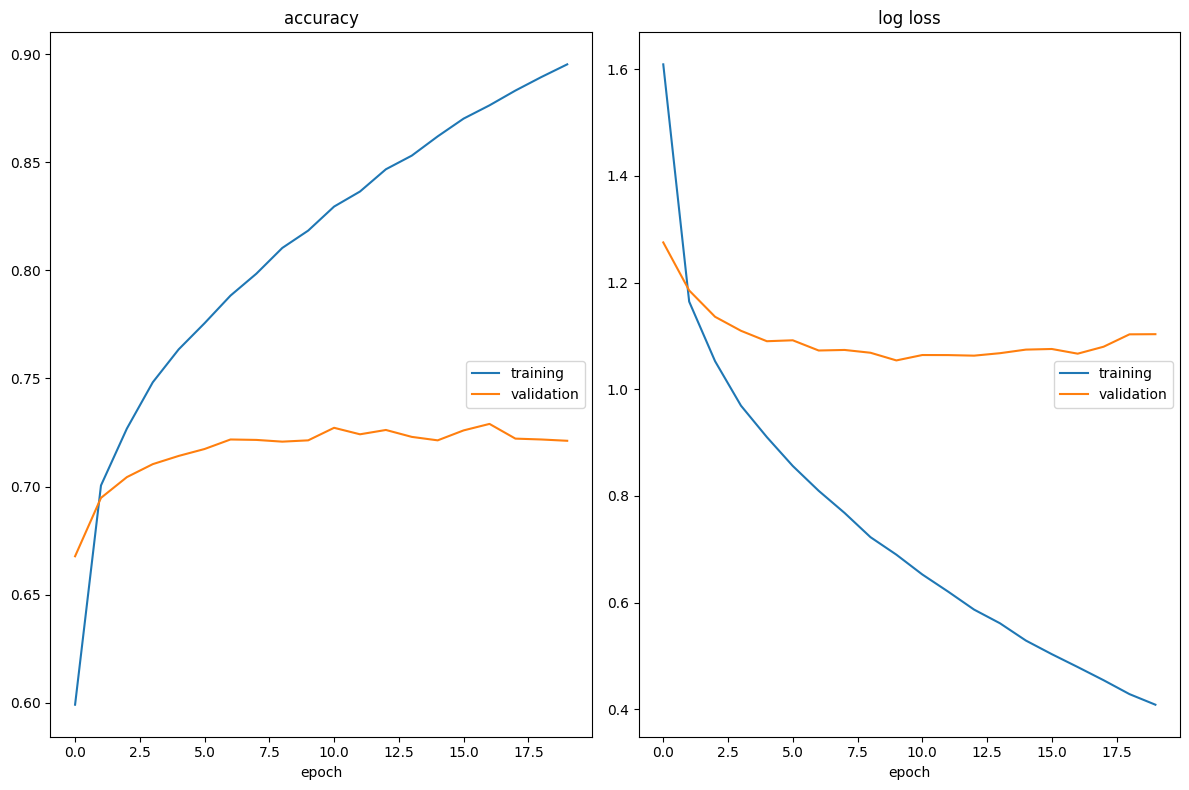

accuracy
	training         	 (min:    0.599, max:    0.895, cur:    0.895)
	validation       	 (min:    0.668, max:    0.729, cur:    0.721)
log loss
	training         	 (min:    0.409, max:    1.609, cur:    0.409)
	validation       	 (min:    1.054, max:    1.275, cur:    1.103)
Training complete in 121m 9s
Best Validation Accuracy: 0.7289999723434448, Epoch: 17


In [55]:
# Train
best_epoch = train_model(
    output_path="ResNet18_FineTune",
    model=model_ft,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_ft,
    device=device,
    num_epochs=20,
)

In [56]:
# Test
model_ft.load_state_dict(torch.load(f"models/ResNet18_FineTune/model_{best_epoch}_epoch.pt"))
test_model(model=model_ft, dataloaders=dataloaders, criterion=criterion, device=device)

Test Loss: 1.0853 Acc: 0.7192
Test complete in 0m 4s
